In [14]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pylab import rcParams
import torch
from torch import nn, distributions
from torch import optim
from torch.utils.data import DataLoader, Dataset, random_split
from tqdm import tqdm
from sklearn.datasets import make_moons
from scipy.stats import gaussian_kde


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on {device.type.upper()}")

rcParams['figure.figsize'] = 5, 5
rcParams['figure.dpi'] = 100

Running on CUDA


In [16]:
class RealNVPBlock(nn.Module):
    def __init__(self, in_features, hidden_features):
        super(RealNVPBlock, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features

        self.net_s = self._build_network()
        self.net_t = self._build_network()

    def _build_network(self):
        return nn.Sequential(
            nn.Linear(self.in_features // 2, self.hidden_features),
            nn.ReLU(),
            nn.Linear(self.hidden_features, self.hidden_features * 2),
            nn.ReLU(),
            nn.Linear(self.hidden_features * 2, self.hidden_features * 2),
            nn.ReLU(),
            nn.Linear(self.hidden_features * 2, self.hidden_features),
            nn.ReLU(),
            nn.Linear(self.hidden_features, self.in_features // 2),
        )

    def forward(self, x):
        x_a, x_b = x.chunk(2, dim=1)
        s = self.net_s(x_a)
        t = self.net_t(x_a)
        y_a = x_a
        y_b = x_b * torch.exp(s) + t
        log_det_jacobian = s.sum(dim=1)
        return torch.cat([y_a, y_b], dim=1), log_det_jacobian

    def backward(self, y):
        y_a, y_b = y.chunk(2, dim=1)
        s = self.net_s(y_a)
        t = self.net_t(y_a)
        x_a = y_a
        x_b = (y_b - t) * torch.exp(-s)
        return torch.cat([x_a, x_b], dim=1)

In [17]:
class RealNVP(nn.Module):
    def __init__(self, num_blocks, in_features, hidden_features):
        super(RealNVP, self).__init__()
        self.blocks = nn.ModuleList([RealNVPBlock(in_features, hidden_features) for _ in range(num_blocks)])
        self.prior = distributions.MultivariateNormal(torch.zeros(in_features).to(device), torch.eye(in_features).to(device))

    def forward(self, x):
        log_det_jacobian = 0
        for block in self.blocks:
            x, ldj = block.forward(x)
            log_det_jacobian += ldj
            x = torch.flip(x, dims=(1,))
        return x, log_det_jacobian

    def backward(self, y):
        for block in reversed(self.blocks):
            y = torch.flip(y, dims=(1,))
            y = block.backward(y)
        return y

    def log_prob(self, x):
        y, log_det_jacobian = self.forward(x)
        log_prob_z = self.prior.log_prob(y)
        return log_prob_z + log_det_jacobian

    def sample(self, batch_size):
        y = self.prior.sample((batch_size,))
        x = self.backward(y)
        return x

In [18]:
def check_for_nan(tensor, name=""):
    if torch.isnan(tensor).any():
        print(f"NaN detected in {name}")
        return True
    return False

In [19]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)

class CustomDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

In [20]:
def plot_samples(samples, title, dim=2):
    samples = samples.detach().numpy()
    if dim == 2:
        plt.figure(figsize=(8, 8))
        plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5)
        plt.title(title)
        plt.xlabel('x1')
        plt.ylabel('x2')
        plt.show()
    elif dim == 3:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(samples[:, 0], samples[:, 1], samples[:, 2], alpha=0.5)
        ax.set_title(title)
        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        ax.set_zlabel('x3')
        plt.show()

def plot_comparison(original_samples, generated_samples, title, dim=2):
    original_samples = original_samples.detach().numpy()
    generated_samples = generated_samples.detach().numpy()
    if dim == 2:
        plt.figure(figsize=(8, 8))
        plt.scatter(original_samples[:, 0], original_samples[:, 1], alpha=0.5, label='Original')
        plt.scatter(generated_samples[:, 0], generated_samples[:, 1], alpha=0.5, label='Generated')
        plt.title(title)
        plt.xlabel('x1')
        plt.ylabel('x2')
        plt.legend()
        plt.show()
    elif dim == 3:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(original_samples[:, 0], original_samples[:, 1], original_samples[:, 2], alpha=0.5, label='Original')
        ax.scatter(generated_samples[:, 0], generated_samples[:, 1], generated_samples[:, 2], alpha=0.5, label='Generated')
        ax.set_title(title)
        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        ax.set_zlabel('x3')
        ax.legend()
        plt.show()

In [21]:
def train_real_nvp(model, train_loader, val_loader, optimizer, scheduler, num_epochs, visualize_epochs, num_samples):
    best_val_loss = float('inf')
    best_model_weights = None
    train_loss = []
    val_loss = []

    for epoch in tqdm(range(num_epochs)):
        model.train()
        total_train_loss = 0

        for x in train_loader:
            x = x.to(device)
            optimizer.zero_grad()
            loss = -model.log_prob(x).mean()
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            scheduler.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_loss.append(avg_train_loss)

        # Validation loss calculation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for x in val_loader:
                x = x.to(device)
                val_loss_batch = -model.log_prob(x).mean()
                total_val_loss += val_loss_batch.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_loss.append(avg_val_loss)

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_weights = model.state_dict().copy()

        if epoch + 1 in visualize_epochs:
            print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
            with torch.no_grad():
                # Visualization of samples from learned distribution
                generated_samples = model.sample(num_samples).cpu()
                plot_samples(generated_samples[:, :2], f'Generated_Samples_at_Epoch_{epoch + 1}', dim=2)

    # Restore best model weights
    model.load_state_dict(best_model_weights)
    torch.save(model.state_dict(), "best_realnvp_model.pth")

    return train_loss, val_loss

  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 1/120, Training Loss: 2.1127, Validation Loss: 2.0099


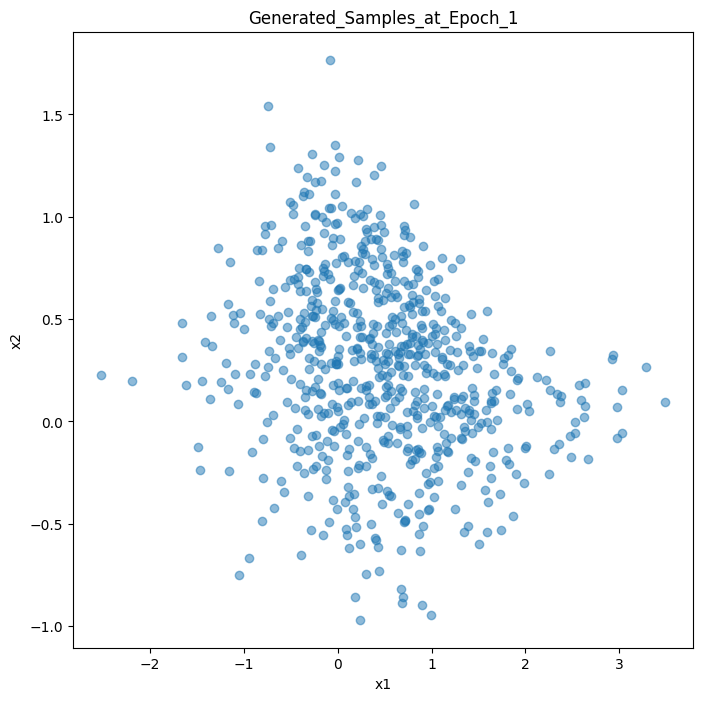

 82%|████████▎ | 99/120 [01:01<00:12,  1.64it/s]

Epoch 100/120, Training Loss: 1.1015, Validation Loss: 1.3199


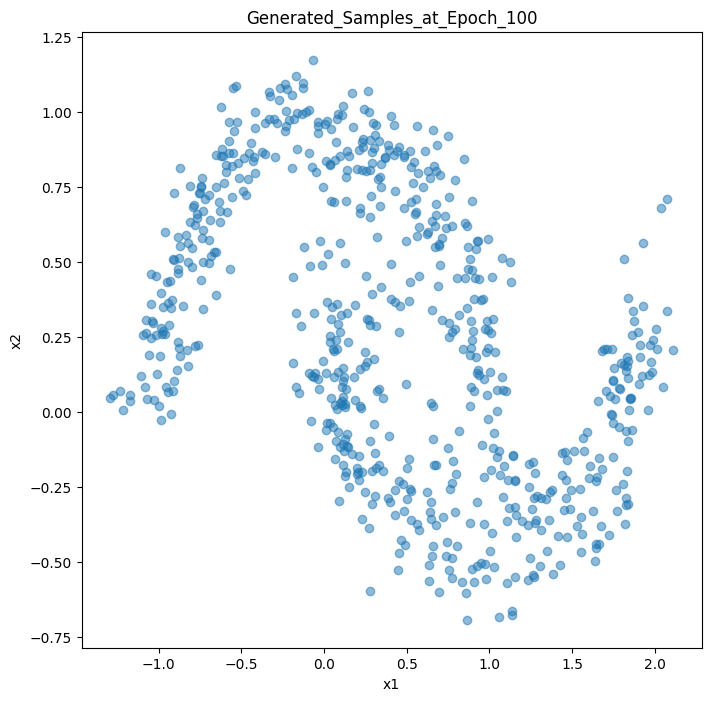

 99%|█████████▉| 119/120 [01:14<00:00,  1.73it/s]

Epoch 120/120, Training Loss: 0.9970, Validation Loss: 1.2996


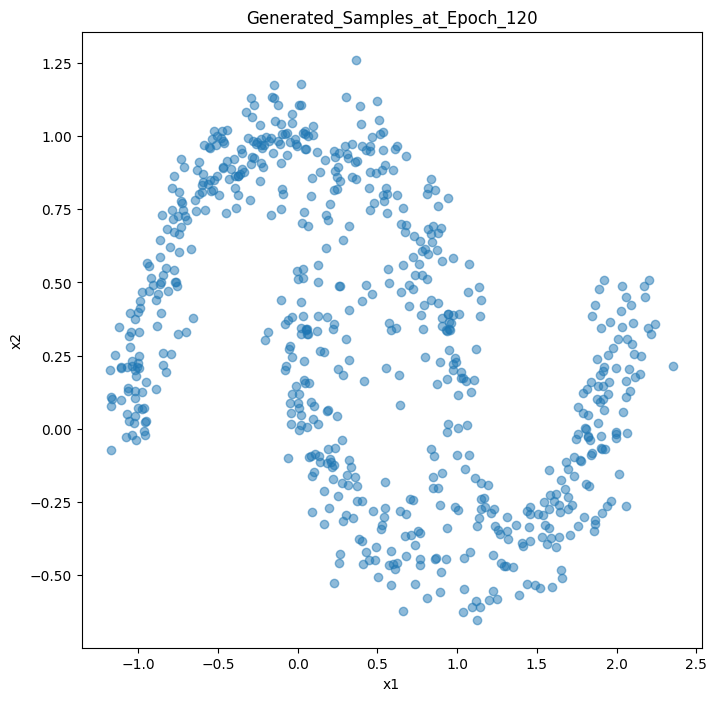

100%|██████████| 120/120 [01:15<00:00,  1.59it/s]


In [22]:
data, _ = make_moons(n_samples=1000, noise=0.1)
target_samples = torch.Tensor(data)

# Split the data into train (2/3) and validation + test (1/3)
train_size = int(2/3 * len(target_samples))
val_size = test_size = (len(target_samples) - train_size) // 2
train_dataset, val_dataset, test_dataset = random_split(target_samples, [train_size, val_size, test_size])

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

dim = target_samples.shape[1]
num_blocks = 8  
hidden_features = 256  
learning_rate = 1e-4  
num_epochs = 120 
visualize_epochs = [1, 100, 120]

model = RealNVP(num_blocks, dim, hidden_features).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.9)

train_loss, val_loss = train_real_nvp(model, train_loader, val_loader, optimizer, scheduler, num_epochs, visualize_epochs, len(train_dataset))

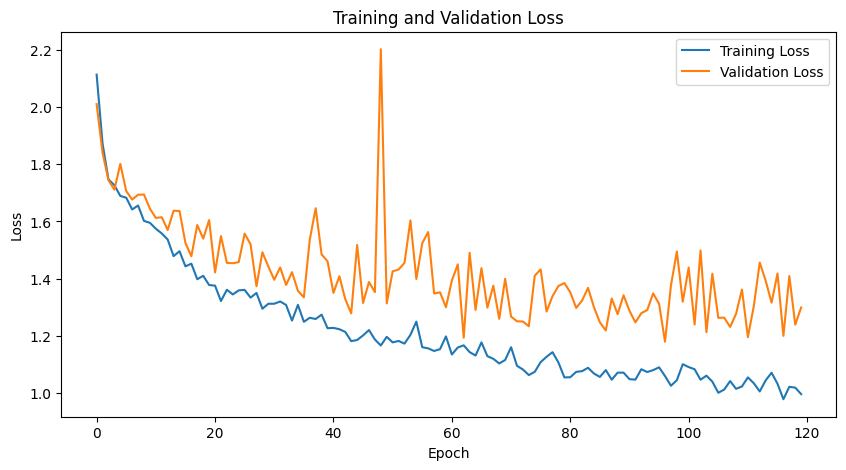

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

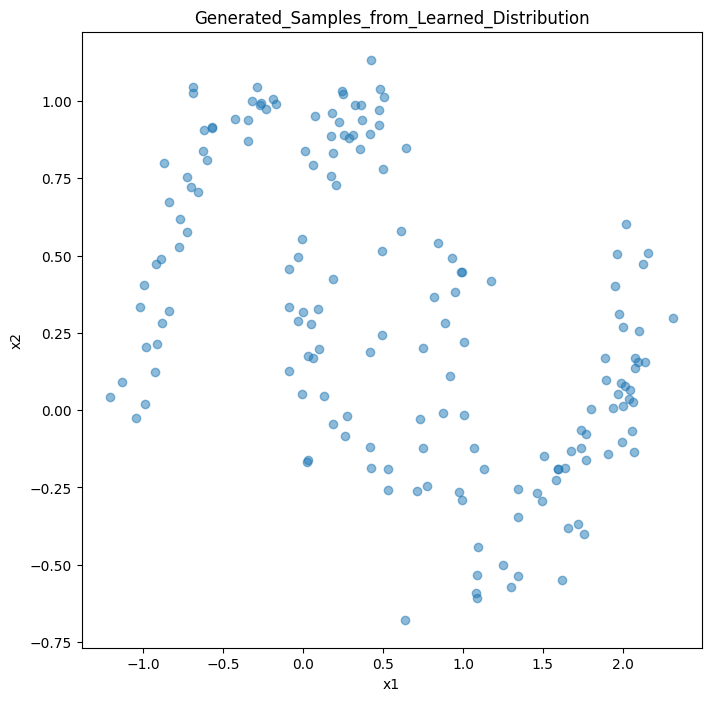

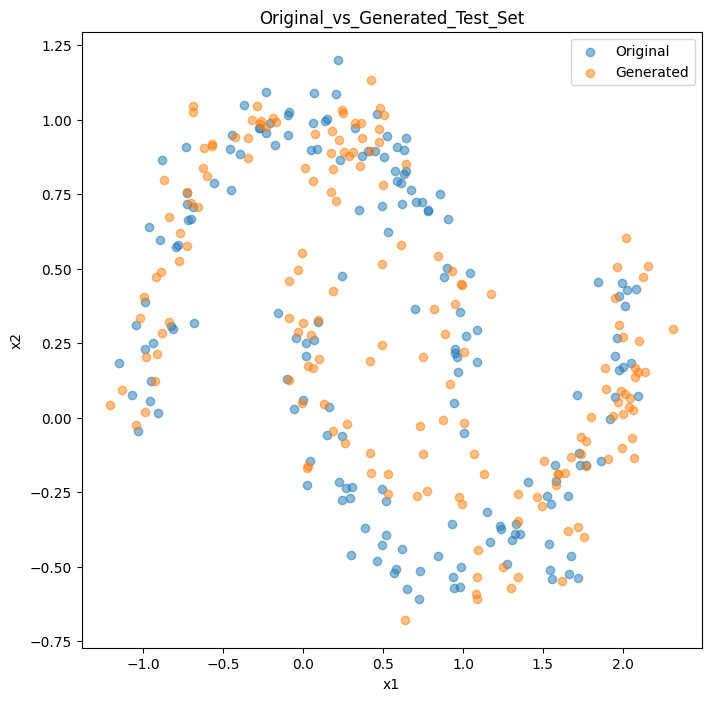

In [24]:
with torch.no_grad():
    generated_samples = model.sample(len(test_dataset)).cpu()
    plot_samples(generated_samples[:, :2], 'Generated_Samples_from_Learned_Distribution', dim=2)

# Plot comparison with original test set
plot_comparison(test_dataset.dataset[:len(test_dataset)][:, :2], generated_samples[:, :2], 'Original_vs_Generated_Test_Set', dim=2)

KDE eval

In [25]:
def compute_data_overlap(original_samples, generated_samples, bandwidth='scott'):
    """
    Computes the probability of overlap between original and generated samples.

    Parameters:
    - original_samples (torch.Tensor): Tensor of original data samples.
    - generated_samples (torch.Tensor): Tensor of generated data samples.
    - bandwidth (str or float): The bandwidth of the kernel. 'scott' or 'silverman' can be used for automatic selection, or specify a float value.

    Returns:
    - overlap_probability (float): The computed probability of overlap between the original and generated samples.
    """
    # Convert samples to numpy for KDE
    original_samples_np = original_samples.detach().numpy().T
    generated_samples_np = generated_samples.detach().numpy().T

    # Ensure both arrays have the same number of samples by sampling the smaller set
    min_samples = min(original_samples_np.shape[1], generated_samples_np.shape[1])
    original_samples_np = original_samples_np[:, np.random.choice(original_samples_np.shape[1], min_samples, replace=False)]
    generated_samples_np = generated_samples_np[:, np.random.choice(generated_samples_np.shape[1], min_samples, replace=False)]

    # Create KDEs for both distributions
    kde_original = gaussian_kde(original_samples_np, bw_method=bandwidth)
    kde_generated = gaussian_kde(generated_samples_np, bw_method=bandwidth)

    # Evaluate the KDEs over the same grid
    sample_points = np.hstack([original_samples_np, generated_samples_np])

    original_density = kde_original(sample_points)
    generated_density = kde_generated(sample_points)

    # Compute overlap as the minimum density at each point
    overlap_density = np.minimum(original_density, generated_density)

    # Integrate the overlap density to get the total overlap probability
    overlap_probability = np.sum(overlap_density) / np.sum(kde_original(sample_points))

    return overlap_probability

Average log-probability of the test set: -1.0957
Average probability of the test set: 0.3343


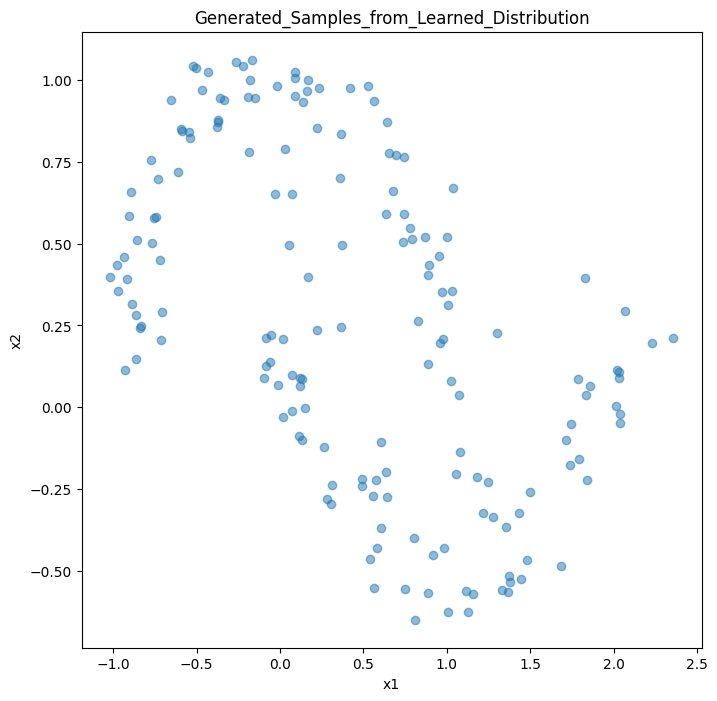

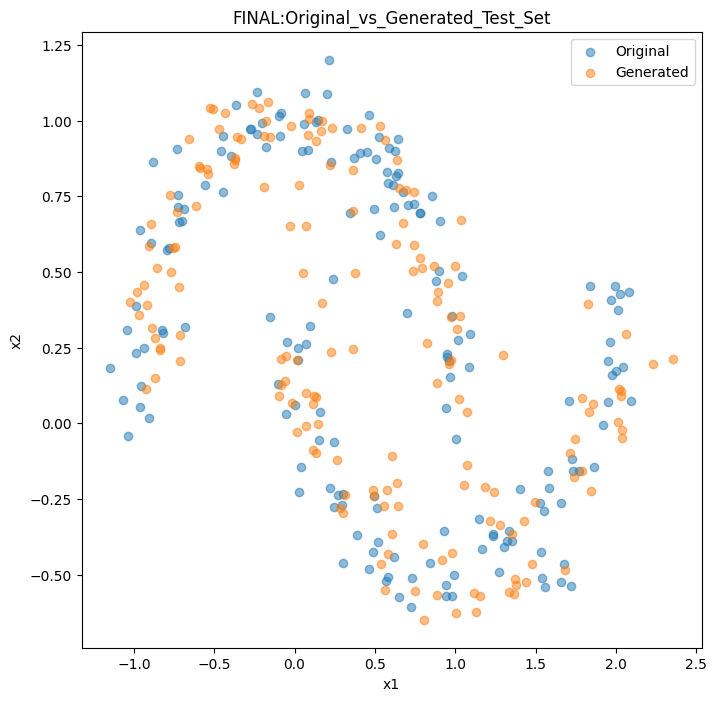

Final probability of data overlap: 0.9431


In [26]:
model.eval()
with torch.no_grad():
    # Generate samples and compare with the test set
    generated_samples = model.sample(len(test_dataset)).cpu()
    plot_samples(generated_samples[:, :2], 'Generated_Samples_from_Learned_Distribution', dim=2)
    plot_comparison(test_dataset.dataset[:len(test_dataset)][:, :2], generated_samples[:, :2], 'FINAL:Original_vs_Generated_Test_Set', dim=2)

model.eval()
with torch.no_grad():
    generated_samples = model.sample(len(test_dataset)).cpu()

    # Extract original samples from the test dataset and slice them to get only the first 2 dimensions
    original_samples = torch.stack([test_dataset[i] for i in range(len(test_dataset))])[:, :2]
    generated_samples = generated_samples[:, :2]

    overlap_probability = compute_data_overlap(original_samples, generated_samples)
    print(f"Final probability of data overlap: {overlap_probability:.4f}")